In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Portolio Optimisation

## Monte Carlo Method

***Problem statement***

*Given a fixed amount of avliable resources, optimise allocation to maximise returns across a set of products with variable returns*

<img src="https://cdn-images-1.medium.com/max/1000/1*QBQXfHZxYzAsbZGqAxa9nw.jpeg" width="500" height="500" />

***Example 1***

Following the Markowitz model, we can formulate our problem as:

*Given a fixed quantity of money (say $1000), how much should we invest in each of the three stocks so as to (a) have a one month expected return of at least a given threshold, and (b) minimize the risk (variance) of the portfolio return.*

Assumptions:
 - We have \\$100 to invest.
 - Risk Free rate of 0.03 (3 % generous)
 - Stocks have a fixed starting price. 
 - Time period is 1 month.
 - The monthly returns of a stock follow a normal distribution with average $mu$ and volatility $sigma$. 
 
***Stocks***

In [2]:
stocks = [ 
           {'n':0,
            'name':'jumanji inc',
            'price':10,
            'mu':0.1,
            'sigma':10},
           {'n':1,
            'name':'evolution ltd',
            'price':20,
            'mu':0.2,
            'sigma':20},
           {'n':2,
            'name':'the incredibles inc',
            'price':30,
            'mu':0.3,
            'sigma':30},
           {'n':3,
            'name':'men in black & co',
            'price':20,
            'mu':0.08,
            'sigma':40},
           {'n':4,
            'name':'goldmember gmbh',
            'price':50,
            'mu':0.05,
            'sigma':15},
           {'n':5,
            'name':'dantes peak',
            'price':10,
            'mu':0.25,
            'sigma':20},
           {'n':6,
            'name':'deep impact',
            'price':20,
            'mu':0.02,
            'sigma':5},
        ]
stocks_df = pd.DataFrame(stocks)
stocks_df

,n,name,price,mu,sigma
0,0,jumanji inc,10,0.10,10
1,1,evolution ltd,20,0.20,20
2,2,the incredibles inc,30,0.30,30
3,3,men in black & co,20,0.08,40
4,4,goldmember gmbh,50,0.05,15
5,5,dantes peak,10,0.25,20
6,6,deep impact,20,0.02,5


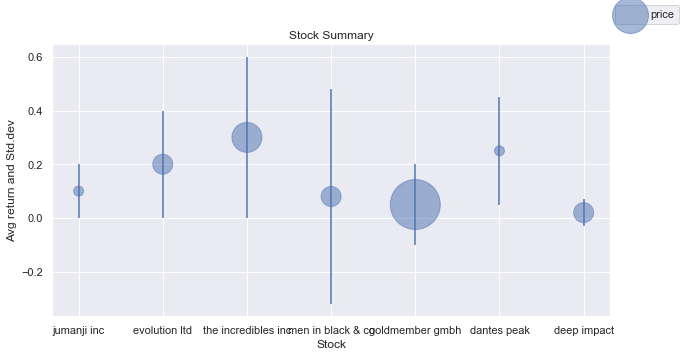

In [3]:
fig,axs=plt.subplots(1,1,figsize=(10,5))
axs.set_title('Stock Summary')
axs.scatter(stocks_df['n'],stocks_df['mu'],s=stocks_df['price']**2,alpha=0.5,label='price')
axs.errorbar(stocks_df['n'],stocks_df['mu'],yerr=stocks_df['sigma']/100,fmt='none')

axs.set_xticks(stocks_df['n'])
axs.set_xticklabels(stocks_df['name'])
axs.set_ylabel('Avg return and Std.dev')
axs.set_xlabel('Stock');
fig.legend();

***Monte Carlo Portfolio's***

Generate random portfolios of value $V$. Method is adapted from this [SO](https://stackoverflow.com/a/36818198/4538066) answer, but is not optimal. 

In [4]:
# total number of stocks in universe
N = len(stocks) 

# V = total to invest 
investment = 10**3 
print(f'Investment: ${investment:.2f}')
      
mc_portfolio_runs = list()
pmax=5000
for p in range(pmax):
    print(f'{p}/{pmax}',end='\r')
    
    # random portfolio size
    portfolio_size = np.random.randint(2, N+1) 

    # create a df portfolio of them
    df = stocks_df.iloc[np.random.choice(N, portfolio_size, replace=False)].copy()

    # sum numbers
    while True:
        df['value'] = np.random.random(portfolio_size)
        T = df['value'].sum()
        if T != 0: break

    # calculate normalised value and number of shares 
    df['value'] *= investment/T
    df['shares'] = df['value']/df['price']
    df['p'] = p
    
    mc_portfolio_runs.append(df)

Investment: $1000.00


In [5]:
mc_portfolios = pd.concat(mc_portfolio_runs).reset_index(drop=True)
mc_portfolios[:2]

,n,name,price,mu,sigma,value,shares,p
0,3,men in black & co,20,0.08,40,201.353368,10.067668,0
1,6,deep impact,20,0.02,5,19.906906,0.995345,0


***Balanced Portfolio***

A portfolio with equal investment in each stock.

In [6]:
balanced_portfolio = stocks_df.copy()
balanced_portfolio['value']=333.33
balanced_portfolio['shares'] = balanced_portfolio['value']/balanced_portfolio['price']
balanced_portfolio['p']='balanced'
balanced_portfolio

,n,name,price,mu,sigma,value,shares,p
0,0,jumanji inc,10,0.10,10,333.33,33.3330,balanced
1,1,evolution ltd,20,0.20,20,333.33,16.6665,balanced
2,2,the incredibles inc,30,0.30,30,333.33,11.1110,balanced
3,3,men in black & co,20,0.08,40,333.33,16.6665,balanced
4,4,goldmember gmbh,50,0.05,15,333.33,6.6666,balanced
5,5,dantes peak,10,0.25,20,333.33,33.3330,balanced
6,6,deep impact,20,0.02,5,333.33,16.6665,balanced


***Calculate Portfolio Risk & Return***

In [7]:
def portfolio_returns(portfolio,risk_free_rate=0.03):
    """
    Calculates portfolio returns, risk and summary
    """
    #calculate returns
    portfolio['result'] = np.random.normal(loc=portfolio['mu'],scale=portfolio['sigma'])*portfolio['shares']

    # calculate risk
    # https://math.stackexchange.com/questions/3381762/how-to-combine-standard-deviations-using-variance
    # sqrt((sum(var1^2+var2^2)))
    portfolio['var'] = portfolio['sigma'].apply(lambda x: x**2)
    
    # portfolio summary
    portfolio_summary = portfolio.groupby('p').agg({'value':sum,'var':sum,'result':sum})
    portfolio_summary['return']= ((portfolio_summary['value']+portfolio_summary['result'])/portfolio_summary['value'])*100.0
    portfolio_summary['risk'] = portfolio_summary['var'].apply(lambda x: np.sqrt(x)/100.)
    
    portfolio_summary['sharpe']=(portfolio_summary['return']-risk_free_rate)/portfolio_summary['risk']
    portfolio_summary.drop(labels=['var'],axis=1,inplace=True)

    return portfolio_summary,portfolio

***Calculate Portfolio Summary***

In [8]:
summary = dict()
summary['MonteCarlo'],mc = portfolio_returns(mc_portfolios)
summary['Balanced'],_ = portfolio_returns(balanced_portfolio)

***Plot Result***

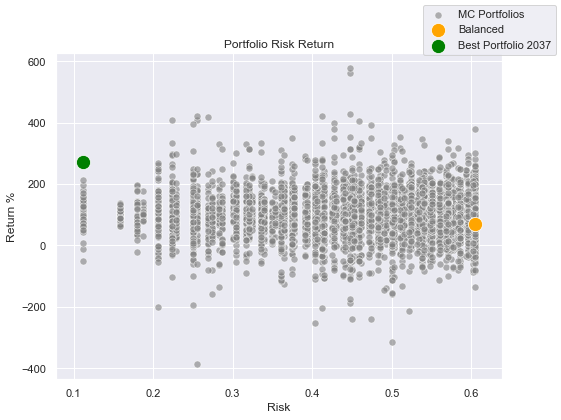

In [9]:
fig,axs = plt.subplots(1,1,figsize=(8,6))
axs.set_title('Portfolio Risk Return')

sns.scatterplot(summary['MonteCarlo']['risk'],
                summary['MonteCarlo']['return'],
                label='MC Portfolios',
                s=50,color='grey',alpha=0.6,ax=axs)

sns.scatterplot(summary['Balanced']['risk'],
                summary['Balanced']['return'],
                label='Balanced',
                s=200,color='orange',alpha=1,ax=axs);

# Best portfolio maximal returns, minimal risk (highest Sharpe ratio)
gd = summary['MonteCarlo'].loc[summary['MonteCarlo'].sharpe.idxmax()]
sns.scatterplot([gd['risk']],
                [gd['return']],
                label=f'Best Portfolio {gd.name}',
                s=200,color='green',alpha=1,ax=axs)

axs.set_xlabel('Risk')
axs.set_ylabel('Return %')
axs.get_legend().remove()
fig.legend(loc='upper right');

In [10]:
# best portfolio 
mc.loc[mc['p']==summary['MonteCarlo'].sharpe.idxmax()]

,n,name,price,mu,sigma,value,shares,p,result,var
9164,6,deep impact,20,0.02,5,187.602982,9.380149,2037,-18.592925,25
9165,0,jumanji inc,10,0.10,10,812.397018,81.239702,2037,1747.558702,100


***Summary***
- This method applies monte carlo (i.e. exhaustive search) to calculate a large number of randomised investment portfolios. 
- Risk, Return, and Sharpe measures are calculated for each of the random portfolios, and for a balanced portfolio (i.e. equal allocation portfolio assuming no knowledge of where to invest). 
- An optimal portfolio is identified using the maximum Sharpe ratio that maximises returns whilst minimising risk.
- Increasing the number of randomised portfolios increases the chances of identifying an optimal portfolio. 
- However, finding the optimal portfolio is not garunteed and decreases with increasing number of investment options, investment returns and variances.

***References:***

- https://towardsdatascience.com/optimization-with-python-how-to-make-the-most-amount-of-money-with-the-least-amount-of-risk-1ebebf5b2f29
- https://colab.research.google.com/github/cvxgrp/cvx_short_course/blob/master/applications/portfolio_optimization.ipynb
- https://insightr.wordpress.com/2017/08/27/pricing-optimization-how-to-find-the-price-that-maximizes-your-profit/
- http://riskdatascience.net/usecases-auswahl/automated-portfolio-optimization-by-combining-ai-and-risk-methods/
- https://towardsdatascience.com/automating-portfolio-optimization-using-python-9f344b9380b9
- https://towardsdatascience.com/best-investment-portfolio-via-monte-carlo-simulation-in-python-53286f3fe93
- https://www.dummies.com/business/accounting/auditing/how-to-optimize-portfolio-risk/